# **Section 1: Setups and Imports** <a id="1"></a>

In [1]:
# 🚀 Always run this cell first! It contains all necessary imports.
import gc
import sys
import pprint
import os

import requests
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import joblib

import gym # openai gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim

import random

import csv

# **Section 2: Functions** <a id="2"></a>

## **2.1. Domain Functions** <a id="2.1"></a>

## **2.2. Utility Functions** <a id="2.2"></a>

# **Section 3: Load Data** <a id="3"></a>

In [2]:
# Example NHL play-by-play API URL (game ID will change per game)
game_id = "2022030411"  # Change this to other game IDs if needed
url = f"https://api-web.nhle.com/v1/gamecenter/{game_id}/play-by-play"

# Fetch data from API
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    
    # Extract relevant events
    events = data.get("plays", [])
    away_Team = data.get("awayTeam", [])
    home_Team = data.get("homeTeam", [])
    extracted_data = []

    for event in events:
        event_details = event.get("details", {})
        event_data = {
            "eventId": event.get("eventId"),
            "period": event.get("periodDescriptor", {}).get("number"),
            "time": event.get("timeInPeriod"),
            "away_team": away_Team.get("abbrev"),
            "home_team": home_Team.get("abbrev"),
            "home_team_side": event.get("homeTeamDefendingSide"),
            "eventType": event.get("typeDescKey"),
        }
        # Add event details to event_data
        if event_details:
            for key, value in event_details.items():
                event_data[key] = value
        
        extracted_data.append(event_data)

    # Convert to DataFrame
    df = pd.DataFrame(extracted_data)

    # Save to CSV
    df.to_csv("../data/csv/nhl_play_by_play.csv", index=False)
    print("Data saved to nhl_play_by_play.csv")

else:
    print("Failed to retrieve data from NHL API. Status code:", response.status_code)


Data saved to nhl_play_by_play.csv


In [3]:
print(f"List of eventType: {df['eventType'].unique()}")

List of eventType: ['period-start' 'faceoff' 'hit' 'blocked-shot' 'stoppage' 'takeaway'
 'giveaway' 'shot-on-goal' 'missed-shot' 'penalty' 'goal'
 'delayed-penalty' 'period-end' 'game-end']


In [4]:
# Define relevant play-driving events
play_events = ["shot-on-goal", 
               "hit", 
               "blocked-shot", 
               "takeaway", 
               "giveaway", 
               "missed-shot",
               "goal"] # goal is kept for reward calculation only; it is not an action choice, its an outcome

# Filter dataset to keep only these events
df_filtered = df[df["eventType"].str.lower().isin(play_events)]


event_counts = df_filtered['eventType'].value_counts()

#print list of eventType and their counts
print(f"List of eventType after filtering: {df_filtered['eventType'].unique()}")
print(event_counts)



List of eventType after filtering: ['hit' 'blocked-shot' 'takeaway' 'giveaway' 'shot-on-goal' 'missed-shot'
 'goal']
eventType
hit             65
shot-on-goal    62
missed-shot     33
blocked-shot    27
giveaway        27
takeaway        21
goal             7
Name: count, dtype: int64


In [5]:
# Replace "shot-on-goal" and "missed-shot" with "shot"
# Both actions will be treated the same - a person doesn't choose to miss a shot, thats an outcome.  We will reward more if shot leads to a goal
df_filtered["eventType"] = df_filtered["eventType"].replace(
    ["shot-on-goal", "missed-shot"], "shot"
)

print(f"List of eventType after replacing shot-on-goal and missed-shot: {df_filtered['eventType'].unique()}")
event_counts = df_filtered['eventType'].value_counts()
print(event_counts)

List of eventType after replacing shot-on-goal and missed-shot: ['hit' 'blocked-shot' 'takeaway' 'giveaway' 'shot' 'goal']
eventType
shot            95
hit             65
blocked-shot    27
giveaway        27
takeaway        21
goal             7
Name: count, dtype: int64


/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_13333/1488009163.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["eventType"] = df_filtered["eventType"].replace(


In [6]:
# remove giveaway event
df_filtered = df_filtered[df_filtered["eventType"] != "giveaway"]

print(f"List of eventType after removing giveaway: {df_filtered['eventType'].unique()}")
event_counts = df_filtered['eventType'].value_counts()
print(event_counts)

List of eventType after removing giveaway: ['hit' 'blocked-shot' 'takeaway' 'shot' 'goal']
eventType
shot            95
hit             65
blocked-shot    27
takeaway        21
goal             7
Name: count, dtype: int64


In [7]:
#print df_filtered columns
print(df_filtered.columns)

Index(['eventId', 'period', 'time', 'away_team', 'home_team', 'home_team_side',
       'eventType', 'eventOwnerTeamId', 'losingPlayerId', 'winningPlayerId',
       'xCoord', 'yCoord', 'zoneCode', 'hittingPlayerId', 'hitteePlayerId',
       'blockingPlayerId', 'shootingPlayerId', 'reason', 'playerId',
       'shotType', 'goalieInNetId', 'awaySOG', 'homeSOG', 'secondaryReason',
       'typeCode', 'descKey', 'duration', 'committedByPlayerId',
       'drawnByPlayerId', 'scoringPlayerId', 'scoringPlayerTotal',
       'assist1PlayerId', 'assist1PlayerTotal', 'awayScore', 'homeScore',
       'discreteClip', 'assist2PlayerId', 'assist2PlayerTotal',
       'servedByPlayerId'],
      dtype='object')


In [8]:
# Map the eventOwnerTeamID (i.e. who initiated the action) from ID to a more readable team name
# Retrieve ID:Team mapping from the NHL API

import requests

response = requests.get("https://api.nhle.com/stats/rest/en/team")
data = response.json()
team_data = data.get("data", [])
team_id_map = {team["id"]: team["triCode"] for team in team_data}

print(team_id_map)

print("Updating dataset with team names...")
df_filtered["eventOwnerTeam"] = df_filtered["eventOwnerTeamId"].map(team_id_map)
df_filtered = df_filtered.drop(columns=["eventOwnerTeamId"])

missing_teams = df_filtered[df_filtered["eventOwnerTeam"].isnull()]
if not missing_teams.empty:
    print("Missing team IDs for the following events:")
    print(missing_teams)
else:
    print("All team IDs are accounted for.")
    
team_distribution = df_filtered["eventOwnerTeam"].value_counts()
print("Team distribution in the dataset:")
print(team_distribution)


{32: 'QUE', 8: 'MTL', 58: 'TSP', 7: 'BUF', 46: 'OAK', 48: 'KCS', 2: 'NYI', 36: 'SEN', 70: 'TBD', 11: 'ATL', 45: 'SLE', 33: 'WIN', 28: 'SJS', 42: 'QBD', 29: 'CBJ', 53: 'ARI', 5: 'PIT', 13: 'FLA', 12: 'CAR', 54: 'VGK', 25: 'DAL', 52: 'WPG', 14: 'TBL', 59: 'UTA', 18: 'NSH', 27: 'PHX', 41: 'MWN', 39: 'QUA', 37: 'HAM', 40: 'DCG', 35: 'CLR', 38: 'PIR', 34: 'HFD', 4: 'PHI', 1: 'NJD', 9: 'OTT', 21: 'COL', 44: 'NYA', 55: 'SEA', 15: 'WSH', 24: 'ANA', 31: 'MNS', 26: 'LAK', 23: 'VAN', 99: 'NHL', 30: 'MIN', 43: 'MMR', 49: 'CLE', 51: 'BRK', 50: 'DFL', 56: 'CGS', 10: 'TOR', 3: 'NYR', 22: 'EDM', 47: 'AFM', 57: 'TAN', 20: 'CGY', 6: 'BOS', 19: 'STL', 16: 'CHI', 17: 'DET'}
Updating dataset with team names...
All team IDs are accounted for.
Team distribution in the dataset:
eventOwnerTeam
FLA    109
VGK    106
Name: count, dtype: int64


In [9]:
# Post-processing: add synthetic actions like pass, carry-in, or dump-in between events
# Why? → This ensures AI learns logical movement patterns.
# These synthetic actions will be added as new rows to the dataset

import pandas as pd
import numpy as np

# Create a new DataFrame to store synthetic actions
synthetic_actions = []

# Iterate through each event in the filtered DataFrame
# and generate synthetic actions based on the eventOwnerTeam and X Coord
for i in range(len(df_filtered) - 1):
    current_event = df_filtered.iloc[i]
    next_event = df_filtered.iloc[i + 1]

    # Check if the same team has possession in consecutive events
    if current_event["eventOwnerTeam"] == next_event["eventOwnerTeam"]:
        x_diff = abs(next_event["xCoord"] - current_event["xCoord"])

        if x_diff > 20:
            action = "carry-in"
            x_coord = current_event["xCoord"] + 10  # Example increment
        else:
            action = "pass"
            x_coord = current_event["xCoord"] + 2  # Example increment

        # Add small random variability to Y-coordinate
        y_coord = current_event["yCoord"] + np.random.randint(-3, 3)  # Add small random variability to Y-coordinate

        # Calculate time halfway between current_event and next_event
        current_time = int(current_event["time"].split(":")[0]) * 60 + int(current_event["time"].split(":")[1])
        next_time = int(next_event["time"].split(":")[0]) * 60 + int(next_event["time"].split(":")[1])
        halfway_time = (current_time + next_time) // 2
        time = f"{halfway_time // 60:02}:{halfway_time % 60:02}"

        synthetic_event = {
            "eventId": None,  # Assign a unique identifier if necessary
            "eventType": action,
            "xCoord": x_coord,
            "yCoord": y_coord,
            "period": current_event["period"],
            "time": time,
            "eventOwnerTeam": current_event["eventOwnerTeam"],
            "away_team": current_event["away_team"],
            "home_team": current_event["home_team"],
            "home_team_side": current_event["home_team_side"],
            "zoneCode": current_event["zoneCode"]
        }

        synthetic_actions.append(synthetic_event)

# Convert the list of synthetic actions to a DataFrame
synthetic_actions_df = pd.DataFrame(synthetic_actions, columns=df_filtered.columns)

# Combine the original DataFrame with the synthetic actions
df_combined = pd.concat([df_filtered, synthetic_actions_df]).sort_values(by=["period", "time"]).reset_index(drop=True)

print(f"Size of original dataset: {df_filtered.shape}")
print(f"Size of synthetic dataset: {len(synthetic_actions)}")
print(f"Size of combined dataset: {df_combined.shape}")


Size of original dataset: (215, 39)
Size of synthetic dataset: 124
Size of combined dataset: (339, 39)


In [10]:
# print list of event types in synthetic_actions_df
print(f"List of eventType in synthetic_actions_df: {synthetic_actions_df['eventType'].unique()}")
event_counts = synthetic_actions_df['eventType'].value_counts()
print(event_counts)

# print list of event types in df_combined
print(f"List of eventType in df_combined: {df_combined['eventType'].unique()}")
event_counts = df_combined['eventType'].value_counts()
print(event_counts)

List of eventType in synthetic_actions_df: ['carry-in' 'pass']
eventType
carry-in    70
pass        54
Name: count, dtype: int64
List of eventType in df_combined: ['hit' 'carry-in' 'pass' 'blocked-shot' 'takeaway' 'shot' 'goal']
eventType
shot            95
carry-in        70
hit             65
pass            54
blocked-shot    27
takeaway        21
goal             7
Name: count, dtype: int64


In [11]:
print(f"List of columns: {df_combined.columns}")

List of columns: Index(['eventId', 'period', 'time', 'away_team', 'home_team', 'home_team_side',
       'eventType', 'losingPlayerId', 'winningPlayerId', 'xCoord', 'yCoord',
       'zoneCode', 'hittingPlayerId', 'hitteePlayerId', 'blockingPlayerId',
       'shootingPlayerId', 'reason', 'playerId', 'shotType', 'goalieInNetId',
       'awaySOG', 'homeSOG', 'secondaryReason', 'typeCode', 'descKey',
       'duration', 'committedByPlayerId', 'drawnByPlayerId', 'scoringPlayerId',
       'scoringPlayerTotal', 'assist1PlayerId', 'assist1PlayerTotal',
       'awayScore', 'homeScore', 'discreteClip', 'assist2PlayerId',
       'assist2PlayerTotal', 'servedByPlayerId', 'eventOwnerTeam'],
      dtype='object')


**Selected Key Columns**
Since the dataset has 39 columns, I reduced it to only the necessary ones for our RL model:

- Game Context: eventId, period, time, away_team, home_team, home_team_side
- Event Type: eventType, eventOwnerTeamId
- Location Data: xCoord, yCoord (where the event happened)
- Shot Details (if applicable): shotType, goalieInNetId
- Game Score: awayScore, homeScore

In [12]:
from tabulate import tabulate

# Select only relevant columns
df_combined = df_combined[[
    "eventId", "period", "time", "away_team", "home_team", "home_team_side",
    "eventType", "eventOwnerTeam", "xCoord", "yCoord", "zoneCode",
    "shotType", "goalieInNetId", "awayScore", "homeScore"
]]

# Count of null values and unique values in each column
column_stats = {
    col: {"Null Count": int(df_combined[col].isnull().sum()), "Unique Count": df_combined[col].nunique()}
    for col in df_combined.columns
}

# Print the combined table
print("Column statistics (Null Count and Unique Count):")
print(tabulate(column_stats.items(), headers=["Column", "Statistics"], tablefmt="grid"))

Column statistics (Null Count and Unique Count):
+----------------+------------------------------------------+
| Column         | Statistics                               |
+================+==========================================+
| eventId        | {'Null Count': 124, 'Unique Count': 215} |
+----------------+------------------------------------------+
| period         | {'Null Count': 0, 'Unique Count': 3}     |
+----------------+------------------------------------------+
| time           | {'Null Count': 0, 'Unique Count': 293}   |
+----------------+------------------------------------------+
| away_team      | {'Null Count': 0, 'Unique Count': 1}     |
+----------------+------------------------------------------+
| home_team      | {'Null Count': 0, 'Unique Count': 1}     |
+----------------+------------------------------------------+
| home_team_side | {'Null Count': 0, 'Unique Count': 2}     |
+----------------+------------------------------------------+
| eventType      | {'

In [13]:
"""" DEAD CODE - No longer filtering out the other team's events so we can use the data as context for reward calculations.  
We will skip them in the step function - we only choose actions for our team
We will need to define team_to_train when setting up the HockeyPlayRL environment

# Set team to train on, and filter it in the data set
team_to_train = "home"  # or "away"
team_to_train_name = home_Team["abbrev"] if team_to_train == "home" else away_Team["abbrev"]

df_combined = df_combined[df_combined["eventOwnerTeam"] == team_to_train_name]  # Only include actions for selected team

print(f"Number of rows after filtering for {team_to_train} team: {df_combined.shape[0]}")"
"""

'" DEAD CODE - No longer filtering out the other team\'s events so we can use the data as context for reward calculations.  \nWe will skip them in the step function - we only choose actions for our team\nWe will need to define team_to_train when setting up the HockeyPlayRL environment\n\n# Set team to train on, and filter it in the data set\nteam_to_train = "home"  # or "away"\nteam_to_train_name = home_Team["abbrev"] if team_to_train == "home" else away_Team["abbrev"]\n\ndf_combined = df_combined[df_combined["eventOwnerTeam"] == team_to_train_name]  # Only include actions for selected team\n\nprint(f"Number of rows after filtering for {team_to_train} team: {df_combined.shape[0]}")"\n'

In [14]:
# Save cleaned data
df_combined.to_csv("../data/csv/nhl_filtered_play_by_play.csv", index=False)

saved_data = pd.read_csv("../data/csv/nhl_filtered_play_by_play.csv")
print(f"Sample of saved data:\n{saved_data.head()}")
print("Filtered data saved as nhl_filtered_play_by_play.csv")

Sample of saved data:
   eventId  period   time away_team home_team home_team_side eventType  \
0      8.0       1  00:23       FLA       VGK          right       hit   
1      NaN       1  00:25       FLA       VGK          right  carry-in   
2      9.0       1  00:27       FLA       VGK          right       hit   
3     10.0       1  00:32       FLA       VGK          right       hit   
4      NaN       1  00:41       FLA       VGK          right      pass   

  eventOwnerTeam  xCoord  yCoord zoneCode shotType  goalieInNetId  awayScore  \
0            FLA    89.0    31.0        O      NaN            NaN        NaN   
1            FLA    99.0    33.0        O      NaN            NaN        NaN   
2            FLA   -14.0    40.0        N      NaN            NaN        NaN   
3            VGK   -86.0    36.0        O      NaN            NaN        NaN   
4            VGK   -84.0    38.0        O      NaN            NaN        NaN   

   homeScore  
0        NaN  
1        NaN  
2      

In [15]:
# Define Deep Q-Network (DQN) model for RL of Hockey Play-by-Play
# Why? → This neural network predicts Q-values for all actions based on the current hockey play.
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)


In [16]:
# Initialize networks
# Why? → We use two networks:
# Online Network (learning agent)
# Target Network (stable reference)
# input_dim = 5 (period, time, xCoord, yCoord, scoreDiff)
# output_dim = 6 (number of actions - hit, blocked_shot, takeaway, giveaway, shot_on_goal, missed_shot, goal)
# Set device (GPU if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
online_network = DQN(input_dim=5, output_dim=6).to(device)
target_network = DQN(input_dim=5, output_dim=6).to(device)
target_network.load_state_dict(online_network.state_dict())  # Copy weights
target_network.eval()  # Target network is frozen


DQN(
  (fc): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
)

In [17]:
# Define Experience Replay Memory
# Why? → Stores past experiences so the AI can learn from past plays instead of just the most recent ones.
# Will be used to train the model - stores Q-values and rewards for each action taken.
# Experience = (state, action, reward, next_state, done)
# Memory = list of experiences
memory = []
max_memory_size = 10000  # Store last 10,000 experiences

def store_experience(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))
    if len(memory) > max_memory_size:
        memory.pop(0)


In [18]:
# Define Epsilon-Greedy Strategy
# Why? → Starts with exploration (ε = 1.0 random actions) and gradually learns to exploit the best moves.
epsilon = 1.0  # Start fully random
epsilon_min = 0.1
epsilon_decay = 0.995  # Reduce randomness over time

def select_action(state):
    if np.random.rand() < epsilon:  # Explore (random action)
        return np.random.randint(0, 6)  # Updated to match output_dim (6 actions)
    else:  # Exploit (use learned Q-values)
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        with torch.no_grad():
            action_taken = torch.argmax(online_network(state_tensor)).item()
            return action_taken


In [19]:
# Define Loss Function & Optimizer
# Why? → We use Mean Squared Error Loss and Adam Optimizer to train the model.
# Why? → This updates the online network so it learns which hockey plays lead to the best outcomes.
loss_fn = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(online_network.parameters(), lr=0.005)  # Adam Optimizer
batch_size = 16  # Number of experiences to sample for training
gamma = 0.99  # Discount factor for future rewards

def train_network():
    if len(memory) < batch_size:
        return  # Don't train until enough experiences are collected

    batch = random.sample(memory, batch_size)  # Sample batch from memory

    for state, action, reward, next_state, done in batch:
        state = torch.tensor(state, dtype=torch.float32).to(device)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
        action = torch.tensor(action).to(device)
        reward = torch.tensor(reward, dtype=torch.float32).to(device)

        # Compute Q-value for current state-action pair
        q_values = online_network(state)
        q_value = q_values[action]  # Predicted: Q-value for selected action in current model (i.e. output of online network with current weights)

        # Compute target Q-value
        with torch.no_grad():
            next_q_values = target_network(next_state)
            target_q_value = reward + (gamma * torch.max(next_q_values)) * (1 - done) # Target: reward + discounted max Q-value for next state (i.e. output of target network with frozen weights) -- the immediate rewards (calculated in Hockey RL env) + discounted future rewards using stable target network

        # Compute loss & update weights
        loss = loss_fn(q_value, target_q_value)  # minize the difference between predicted and target Q-values
        optimizer.zero_grad()
        loss.backward()  # Backpropagation
        optimizer.step() # Update weights to minimize loss (i.e. improve Q-value predictions to be closer to Q-value for that state-action pair)


In [20]:
print(f"Count of values by eventType...\n{df_combined['eventType'].value_counts()}")


Count of values by eventType...
eventType
shot            95
carry-in        70
hit             65
pass            54
blocked-shot    27
takeaway        21
goal             7
Name: count, dtype: int64


In [21]:
# Updated Hockey Play-by-Play RL Environment with Training Logic
# Why? → This version includes training logic to update the online network based on past experiences.
# Calculates reward based on actual event in dataset and chosen action by the agent. How? → Assigns rewards based on event type.
class HockeyPlayRL(gym.Env):
    def __init__(self, df, team_to_train_name, model=None):
        super(HockeyPlayRL, self).__init__()
        self.df = df.reset_index(drop=True)
        self.action_space = spaces.Discrete(7)  # 7 actions now
        self.observation_space = spaces.Box(
            low=np.array([1, 0, -100, -50, -10]),
            high=np.array([3, 1200, 100, 50, 10]),
            dtype=np.float32
        )
        self.current_step = 0
        self.team = team_to_train_name
        self.model = model

    def reset(self):
        """Reset the environment."""
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        """Get current game state as RL observation, adjusting for team perspective."""
        row = self.df.iloc[self.current_step]
        period = row["period"]
        time = int(row["time"].split(":")[0]) * 60 + int(row["time"].split(":")[1])
        # Adjust X-coordinates if in even-numbered periods (switch sides)
        x_coord = row["xCoord"] if not np.isnan(row["xCoord"]) else 0
        if period % 2 == 0:  # Flip X for even periods
            x_coord = -x_coord
        y_coord = row["yCoord"] if not np.isnan(row["yCoord"]) else 0
        score_diff = (row["awayScore"] - row["homeScore"]) if not np.isnan(row["awayScore"]) else 0
        return np.array([period, time, x_coord, y_coord, score_diff], dtype=np.float32)

    # Action-to-reward mapping
    # Assign rewards based on chosen action and actual event in dataset
    # If chosen action matches actual event, assign reward based on event type
    # If not, reward is 0
    # I.e. if the agent chooses what actually happened, it gets rewarded based on the event type
    # This rewards the agent for making the right decisions 
    # and helps it learn which plays are most effective in different situations
    # If it predicts right, it means the weights are updated correctly
    def step(self, action):
        """Apply an action and transition to the next state, ensuring AI only makes decisions on its team's actions."""
        
        # Look up action name by calling action_name function
        action_name = self.action_name(action)  # Convert index to action string

        reward = 0 # Initialize reward

        # Assign base rewards for actions
        if action_name == "shot":
            reward = 3  # Base reward for taking a shot

            # Check if the next event is a goal for our team - increase the reward (benefit)
            if self.current_step < len(self.df) - 1:
                next_event = self.df.iloc[self.current_step + 1]
                if next_event["eventType"] == "Goal" and next_event["eventOwnerTeam"] == self.team:
                    reward += 7  # Extra reward for a goal

        elif action_name == "takeaway":
            reward = 2  # Reward for stealing the puck

        elif action_name == "hit":
            reward = 1  # Reward for delivering a hit

        elif action_name == "blocked-shot":
            reward = 2  # Reward for blocking a shot

        elif action_name == "pass":
            reward = 2  # Encouraging team play

        elif action_name == "carry-in":
            reward = 3  # Encouraging zone entry

        # Check if possession is lost after non-shot actions - reduce the reward (penalty)
        if action_name in ["takeaway", "pass", "carry-in"]:
            if self.current_step < len(self.df) - 1:
                next_event = self.df.iloc[self.current_step + 1]
                if next_event["eventOwnerTeam"] != self.team:  # Lost possession
                    reward -= 2  

        # Move to the next decision-making event (skip opponent events)
        while self.current_step < len(self.df) - 1:
            self.current_step += 1
            if self.df.iloc[self.current_step]["eventOwnerTeam"] == self.team:
                break  # Stop when we reach our team's next action

        done = self.current_step >= len(self.df) - 1
        return self._next_observation(), reward, done, {}
    
    def predict_best_action(self, state):
        """Predict the best action using the trained model."""
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = self.model(state_tensor)
            action = torch.argmax(q_values).item()
        return action

    # Function to look up action name from index
    def action_name(self, action):
        action_mapping = {
            0: "hit",
            1: "blocked-shot",
            2: "takeaway",
            3: "pass",
            4: "carry-in",
            5: "shot"
        }
        return action_mapping[action]

In [22]:
# Re-initialize Hockey RL Environment with Training Logic
team_to_train = "home"
team_to_train_name = home_Team["abbrev"] if team_to_train == "home" else away_Team["abbrev"]
hockey_env_rl = HockeyPlayRL(df_combined, team_to_train_name)

# Set device (GPU if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

/Users/liammckendry/hockey_ai/lib/python3.13/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [23]:
# Define Target Network Update
# Why? → The target network is updated every few episodes to keep learning stable.
def update_target_network():
    target_network.load_state_dict(online_network.state_dict())  # Copy weights

In [24]:
# Define epsilon_decay
# Why? → Reduces randomness over time as the AI learns to exploit the best moves.
def update_epsilon():
    global epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)  # Reduce randomness over time


In [26]:
# Train the Deep Q-Network (DQN) for Hockey Play-by-Play
# This runs thousands of simulated hockey games until the AI masters play selection. 🏆

num_episodes = 100  # Number of episodes (games) to play
skip_training = True  # Skip training if already trained

if skip_training:
    print("Training skipped. Loading pre-trained model...")
    online_network = torch.load("../models/hockey_play_rl_online.pth")
    target_network = torch.load("../models/hockey_play_rl_target.pth")
    print("Model loaded.")
    sys.exit()
    
for episode in range(num_episodes):
    state = hockey_env_rl.reset()  # Reset game (start new episode with Hockey RL Environment)
    done = False

    while not done:  # Goes through each row in the dataset (definition of done)
        action = select_action(state)  # Step 3: Choose action (start with random actions, then exploit learned Q-values - i.e. choose best action)
        next_state, reward, done, _ = hockey_env_rl.step(action)  # Step 4: For the chosen action, get the next state (i.e. observations/features), reward of chosen action (either hard-coded rewards if choose same as eventType in dataset or 0 if not), and if the game is done
        store_experience(state, action, reward, next_state, done)  # Step 5: Store experience (state/observations, chosen action, reward, next state/observation, if done)
        train_network()  # Step 6: Train neural network -- update weights to minimize loss between predicted q-value (current model output for chosen action) and target q-value (immediate reward of chosen action if the same as dataset + future reward of next state/sitauation in dataset) (i.e. improve Q-value predictions to be closer to Q-value for that state-action pair)
        state = next_state  # Move to next state (situational observations in dataset); continue until done all rows in dataset

    update_target_network()  # Step 6: Update target network every episode (going through all rows in dataset)
    update_epsilon()  # Step 7: Reduce exploration (ε) over time to go from random actions to exploiting learned Q-values

    # Print progress every 100 episodes
    if episode % 10 == 0:
        print(f"Episode {episode} completed. Epsilon: {epsilon:.2f}")

print("Training complete!")


Training skipped. Loading pre-trained model...


FileNotFoundError: [Errno 2] No such file or directory: '../models/hockey_play_rl_online.pth'

In [27]:
import os

# Define file paths
online_network_path = "../src/models/dqn_model-online_network.pkl"
target_network_path = "../src/models/dqn_model-target_network.pkl"

# Check if the model files already exist
if os.path.exists(online_network_path) and os.path.exists(target_network_path):
    # Load existing models
    with open(online_network_path, "rb") as model_file:
        online_network = pickle.load(model_file)
    with open(target_network_path, "rb") as model_file:
        target_network = pickle.load(model_file)
    print("Loaded existing models.")
else:
    # Save the trained models
    with open(online_network_path, "wb") as model_file:
        pickle.dump(online_network, model_file)
    with open(target_network_path, "wb") as model_file:
        pickle.dump(target_network, model_file)
    print("Saved new models.")

Loaded existing models.


In [28]:
# Simulate a variety of hockey game states, call predict_best_action(state), and log the AI’s decisions to your hockey_action_log.csv file.

# Log file path
log_file = "../outputs/hockey_action_log.csv"
reward_log = []  # Store total reward per episode

# Number of simulated entries
num_simulated_states = 1000  # Adjust as needed

# Open log file in append mode
with open(log_file, "a", newline="") as file:
    writer = csv.writer(file)

    # Write header if file is empty
    if file.tell() == 0:
        writer.writerow(["Period", "Time", "X Coord", "Y Coord", "Score Diff", "Action", "Action Name"])

    # Set online network for prediction
    hockey_env_rl.model = online_network

    # Generate random hockey states and predict actions
    for _ in range(num_simulated_states):
        period = np.random.randint(1, 4)  # Period 1-3
        time = np.random.randint(0, 1200)  # Time in seconds (up to 20 min)
        x_coord = np.random.randint(-100, 100)  # Rink width range
        y_coord = np.random.randint(-50, 50)  # Rink height range
        score_diff = np.random.randint(-5, 5)  # Score difference range (-5 to +5)

        # Create state array
        state = [period, time, x_coord, y_coord, score_diff]

        # Move state to the same device as the model
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)

        # Predict AI's best action
        action = hockey_env_rl.predict_best_action(state_tensor)
        action_name = hockey_env_rl.action_name(action)

        # Log result
        writer.writerow(state + [action, action_name])

print("Simulation complete! Logged simulated states to hockey_action_log.csv")


/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_13333/2632909045.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)


Simulation complete! Logged simulated states to hockey_action_log.csv


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_action_heatmaps(log_df):
    """
    Generate KDE (density) heatmaps for AI decision-making locations.

    Parameters:
        log_df (pd.DataFrame): DataFrame with columns ["X Coord", "Y Coord", "Action Name"]
    """
    unique_actions = log_df["Action Name"].unique()
    
    plt.figure(figsize=(15, 10))
    
    for i, action in enumerate(unique_actions, 1):
        plt.subplot(2, 3, i)
        subset = log_df[log_df["Action Name"] == action]
        
        sns.kdeplot(x=subset["X Coord"], y=subset["Y Coord"], cmap="coolwarm", fill=True, levels=100)
        plt.title(f"Heatmap of {action}")
        plt.xlabel("X Coord")
        plt.ylabel("Y Coord")

        # Add offensive/neutral/defensive zone lines
        min_x, max_x = log_df["X Coord"].min(), log_df["X Coord"].max()
        range_x = max_x - min_x
        plt.axvline(x=min_x + range_x * 0.33, color="blue", linestyle="--")
        plt.axvline(x=min_x + range_x * 0.66, color="blue", linestyle="--")
        plt.axvline(x=min_x + range_x * 0.5, color="red", linestyle="-")

    plt.tight_layout()
    
    # Save plot as image
    datetime = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f"../outputs/heatmap_actions_zones_{datetime}.png", bbox_inches='tight')
    
    plt.show()

    

Count of actions in df_log:
Action Name
shot            970
blocked-shot     25
carry-in          5
Name: count, dtype: int64
Min X Coord: -100, Max X Coord: 99, Range of X Coord: 199
Min Y Coord: -50, Max Y Coord: 49, Range of Y Coord: 99


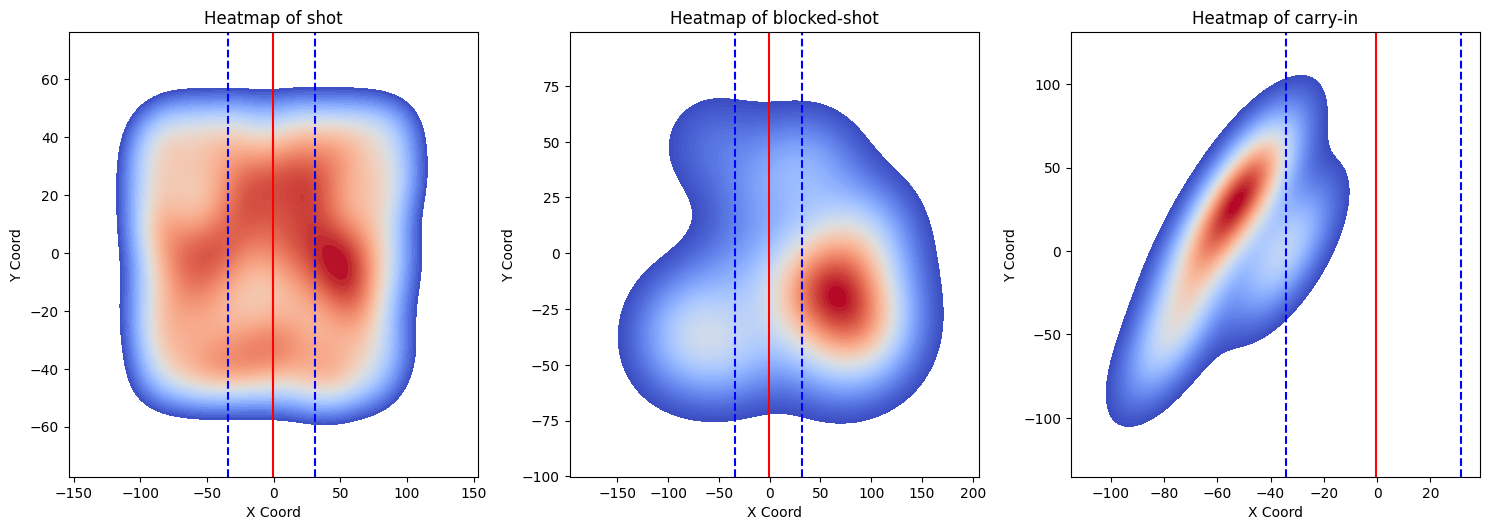

In [31]:
# Load the hockey action log as df_log
df_log = pd.read_csv(log_file)

# Print count of actions in df_log
print(f"Count of actions in df_log:\n{df_log['Action Name'].value_counts()}")

# Print min and max of X Coord and Y Coord in df_log
print(f"Min X Coord: {df_log['X Coord'].min()}, Max X Coord: {df_log['X Coord'].max()}, Range of X Coord: {df_log['X Coord'].max() - df_log['X Coord'].min()}")
print(f"Min Y Coord: {df_log['Y Coord'].min()}, Max Y Coord: {df_log['Y Coord'].max()}, Range of Y Coord: {df_log['Y Coord'].max() - df_log['Y Coord'].min()}")

# Plot heatmaps for each action type showing where on the rink the AI makes different plays
plot_action_heatmaps(df_log)

In [32]:
reward_log = []  # Store total reward per episode
num_episodes = 10  # Number of episodes to simulate
episode_length = 100  # Max steps per episode

for episode in range(num_episodes):
    # Reset environment for new episode and return first state
    state = hockey_env_rl.reset()
    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)

    done = False  # Episode completion flag
    total_reward = 0  # Track cumulative reward for this episode
    
    for step in range(episode_length):  # Limit episode length
        action = hockey_env_rl.predict_best_action(state_tensor)  # Predict best action
        next_state, reward, done, _ = hockey_env_rl.step(action)

        total_reward += reward  # Accumulate rewards
        
        # ✅ Fix: Update `state` to `next_state` for next iteration
        state = next_state
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)  # Move to device

        if done:
            break  # Stop episode if max steps reached

    reward_log.append(total_reward)  # Store total reward for episode
    print(f"Episode {episode} completed. Total Reward: {total_reward}")

# Save reward log as CSV
reward_df = pd.DataFrame(reward_log, columns=["Reward"])
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
reward_df.to_csv(f"../outputs/hockey_reward_log_{timestamp}.csv", index=False)

print("Simulation complete! Logged rewards per episode.")


/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_13333/2632909045.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)


Episode 0 completed. Total Reward: 300
Episode 1 completed. Total Reward: 300
Episode 2 completed. Total Reward: 300
Episode 3 completed. Total Reward: 300
Episode 4 completed. Total Reward: 300
Episode 5 completed. Total Reward: 300
Episode 6 completed. Total Reward: 300
Episode 7 completed. Total Reward: 300
Episode 8 completed. Total Reward: 300
Episode 9 completed. Total Reward: 300
Simulation complete! Logged rewards per episode.


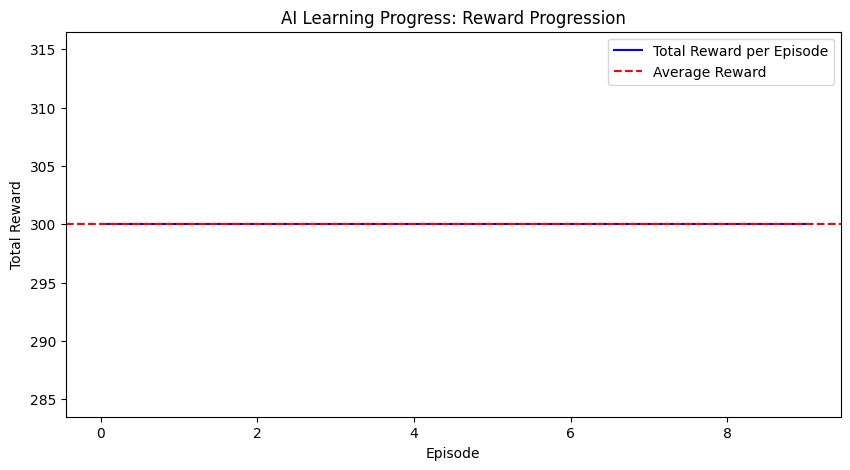

In [33]:
def plot_reward_progression(reward_log):
    """
    Plot reward progression over training episodes.
    
    Parameters:
        reward_log (list): List of cumulative rewards per episode.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(reward_log, label="Total Reward per Episode", color="blue")
    plt.axhline(y=np.mean(reward_log), color="red", linestyle="--", label="Average Reward")
    
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("AI Learning Progress: Reward Progression")
    plt.legend()
    plt.show()

# Run this after training
plot_reward_progression(reward_log)


# **Section 4: Pre-Process Data** <a id="4"></a>

# **Section 5: Model** <a id="5"></a>

## **5.1. Model Definition** <a id="5.1"></a>


## **5.2. Model Training** <a id="5.2"></a>

 ## **5.3. Model Evaluation** <a id="5.3"></a>